In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from predictor import Predictor

# Запись данных

Здесь в примере данные записывюатся из json-файла, но код можно переписать и подавать сообщения из Kafka

In [2]:
model = Predictor()
# load data to model
import json

with open('data.json', 'r') as f:
    data = json.load(f)

for timestamp in data:
    model.write_mes(timestamp)

Пример сообщения

In [3]:
#print(data[0])

# Подбор параметров
После того как загружено достаточное число данных можно запустить метод, чтобы подобрать коэфиценты тренда или любой другой имплеменитрвоанной модели

In [4]:
model.fit(n_days=30)

# Предсказание
После того как были заданы предупредительные значения для вибраций, можно запустить метод для предсказания даты выхода из строя. 

Важно!
 - В качестве даты выхода для каждого подшипника будет передана наискорейшая дата по всем вибрациям (горизонт, верт и аксиальные)
 - Дата прогнозируется только для тех подшипников, для которых есть амлитуда вибраций в Kafka

 Выходные данные:

 Словарь, ключ - индекс подшипника, 
 значение - (delta-время в днях с 2022.01.01 00:00 , ошибка по времени в днях, причина отказа (ключ для вибраций))

In [5]:
model.predict_linear()

{0: (-2087.102159796671, 64.67092430829885, 'Vibration_axis'),
 1: (-2104.051843272536, 252.0263249559547, 'Vibration_vertical'),
 6: (446.23141356923765, 5.627110257647304, 'Vibration_vertical'),
 7: (460.4029877221352, 4.187229810951695, 'Vibration_horizntal')}

# Визуализация данных
это уже просто как пример что можно и обращаться к функции тренда в модели явно для потсроения графиков

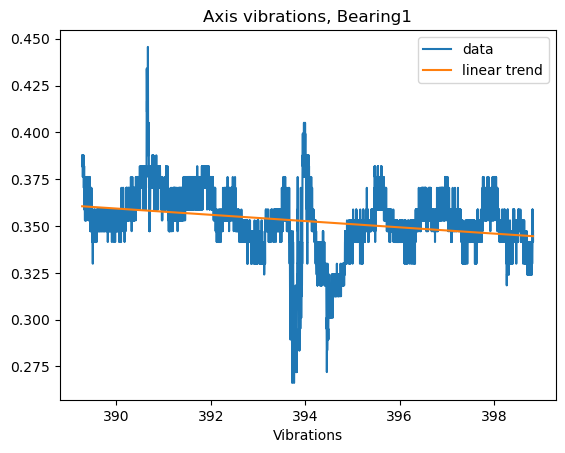

In [6]:
plt.title('Axis vibrations, Bearing1')

plt.plot(model.t, model.data_value[0]['Vibration_axis'], label='data')

t_pred = np.array([model.t[0], model.t[-1]])

plt.plot(t_pred, model.trend_linear(t_pred, 'Vibration_axis', 0), label='linear trend')
plt.legend()
plt.xlabel('days')
plt.xlabel('Vibrations')
plt.show()

In [7]:
x = model.data_value[0]['Vibration_horizntal']
model.t

[389.2725115740741,
 389.2732060185185,
 389.27390046296296,
 389.2745949074074,
 389.2752893518518,
 389.2759837962963,
 389.27667824074075,
 389.2773726851852,
 389.2780671296296,
 389.27876157407405,
 389.27945601851854,
 389.280150462963,
 389.2808449074074,
 389.28153935185185,
 389.2822337962963,
 389.2829282407407,
 389.2836226851852,
 389.28431712962964,
 389.2850115740741,
 389.2857060185185,
 389.28640046296294,
 389.2870949074074,
 389.28778935185187,
 389.2884837962963,
 389.28917824074074,
 389.2898726851852,
 389.2905671296296,
 389.2912615740741,
 389.29195601851853,
 389.29265046296297,
 389.2933449074074,
 389.29403935185184,
 389.29473379629627,
 389.29542824074076,
 389.2961226851852,
 389.29681712962963,
 389.29751157407406,
 389.2982060185185,
 389.298900462963,
 389.2995949074074,
 389.30028935185186,
 389.3009837962963,
 389.3016782407407,
 389.30237268518516,
 389.30306712962965,
 389.3037615740741,
 389.3044560185185,
 389.30515046296296,
 389.3058449074074,
 3